# 0.0 Imports

In [1]:
# data manipulation
import pandas as pd
import numpy  as np

# data visutalization
import matplotlib.pyplot as plt
import seaborn           as sns

# stats
import scipy as ss

#encoding
from imblearn.combine      import SMOTETomek
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder

# feature selection
from boruta                    import BorutaPy
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

# modeling
from sklearn.ensemble    import RandomForestClassifier
from sklearn.ensemble    import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn             import base
from sklearn             import linear_model as lm
from sklearn             import neighbors    as nh
import                          xgboost      as xgb

# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#metrics
import scikitplot as skplt
from   sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score

# tuning
import optuna

#display
from IPython.display       import Image
from IPython.core.display  import HTML

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'fivethirtyeight' )
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    #sns.set()
    sns.set_style('ticks')
    

def get_summary(numerical_attributes):
    
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m



class KFoldTargetEncoder(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        
    def fit(self, X, y=None):
        
        return self
    
    
    def transform(self,X):
    
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2021)
        print(kf)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            
            #train set and validation set
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            
            #test set you take the average of the target values of all samples that have a given category in the entire train set.
            X[col_mean_name].fillna(mean_of_target, inplace = True)
            
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            
        return X



def precision_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']



def recall_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


    
def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    accuracy_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 20000)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 20000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        accuracy = accuracy_score(y_val_fold, yhat_1)
        accuracy_list.append(balanced_accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(balanced_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [5]:
df = pd.read_csv('../data/raw/train.csv')

# 1.0 Data Description

In [6]:
df1 = df.copy()

In [7]:
df1.columns = map(str.lower, df1.columns)

In [8]:
df1.head(7)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0


In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [11]:
cons = pd.DataFrame({'missing' : df.isna().sum(),
                     'size' : df.shape[0],})

cons['percentual'] = round(cons['missing'] / cons['size'],2)

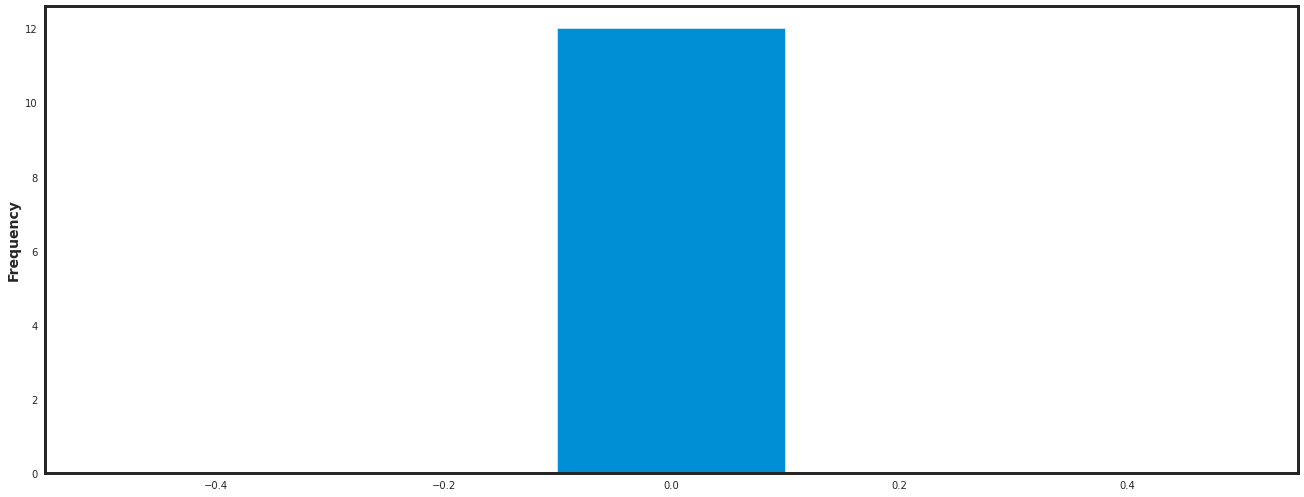

In [12]:
cons.percentual.plot.hist( bins = 5);

In [13]:
num_attributes = df1.select_dtypes( include = [ 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.1 Numerical Attributes

Check for cardinality, distribution, rare labels, imbalanced features and target, skewed data, and more. 

In [14]:
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


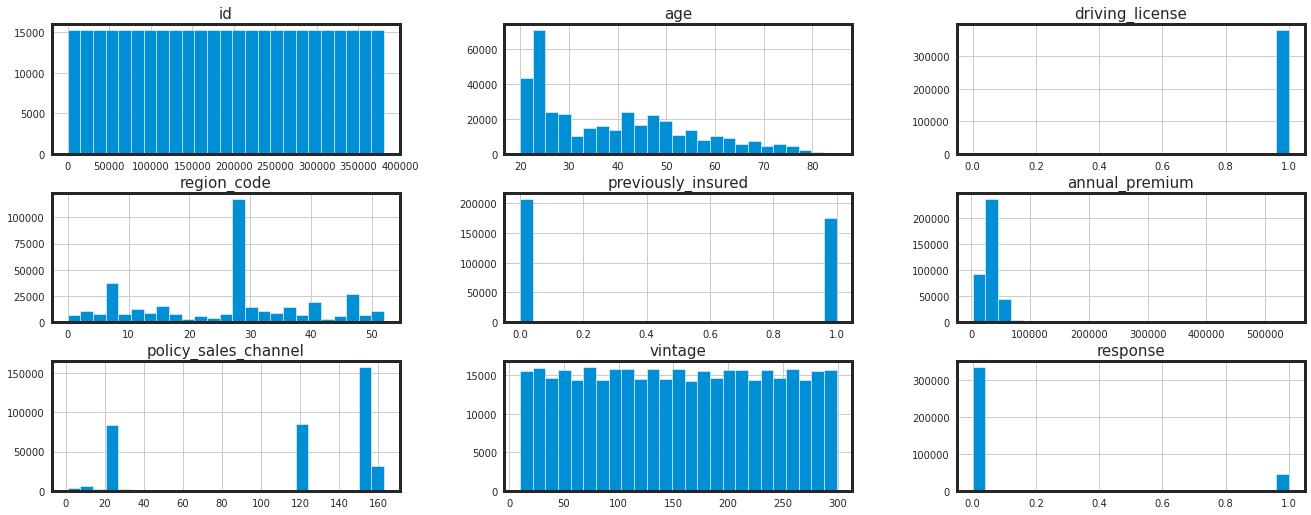

In [15]:
num_attributes.hist(bins = 25);

## 1.2 Categorical Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

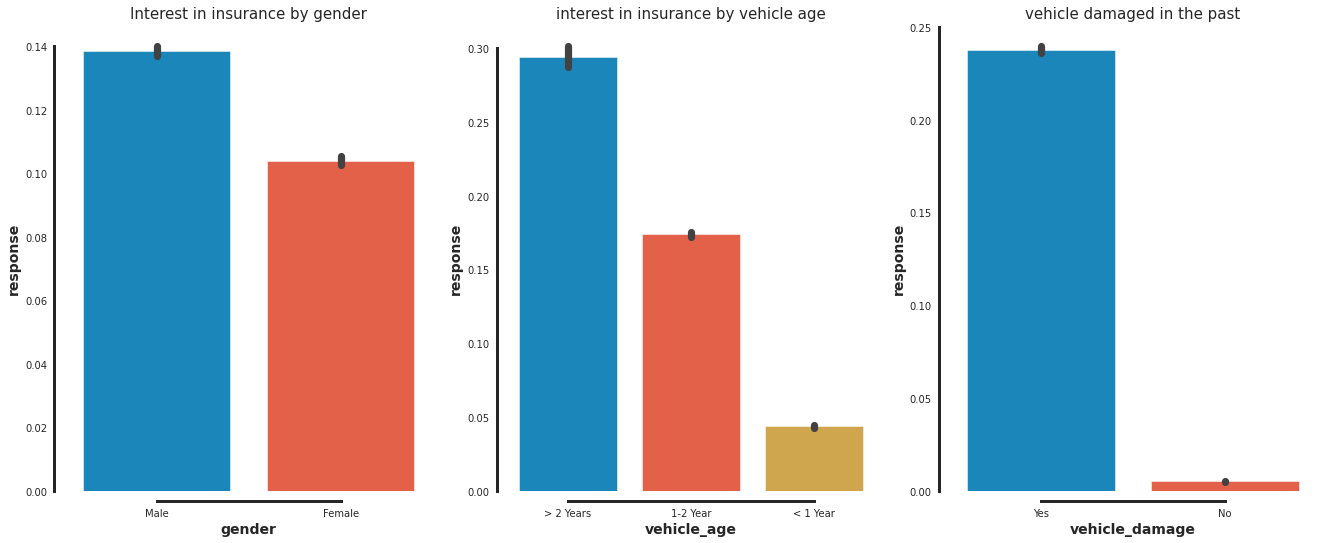

In [17]:
plt.subplot( 1, 3, 1 )
sns.barplot( x='gender', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('Interest in insurance by gender')

plt.subplot( 1, 3, 2 )
sns.barplot( x='vehicle_age', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('interest in insurance by vehicle age')

plt.subplot( 1, 3, 3 )
sns.barplot( x='vehicle_damage', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('vehicle damaged in the past');

## 1.3 Target

In [18]:
df1['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

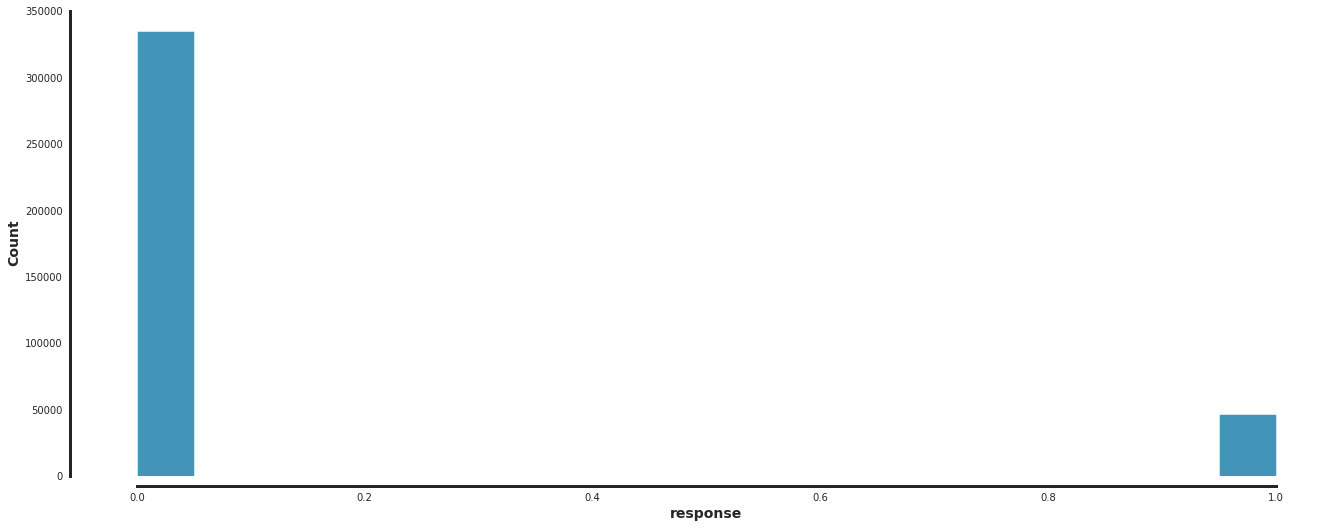

In [19]:
sns.histplot(df1, x = 'response')
sns.despine(offset = 10, trim = True);

# 2.0 Hypothesis

- People is equaly interested in insurance regardless their gender
**FALSE**
- The older the vehicle the greater is the interest in acquiring an insurance
**TRUE**
- If the owner damaged his vehicle before, he is more likely to acquire an insurance
**TRUE**
- People who has driving license are more interested in insurance
**FALSE**
- Different regions have different interesst in insurance
**TRUE**
- Different policy sales channel have different outcome for the customer
**TRUE**
- Who was previosly insured is less likely to acquire a new insurance service (had already showed commitment)
**TRUE**
- The higher Annual Premium, the lower interest in insurance
**FALSE**
- The higher vintage, the higher interest in insurance
**FALSE**
- The higher age, the higher interest in insurance
**TRUE**

# 3.0 Exploratory Data Analysis

In [20]:
df2 = df1.copy()

## 3.1 People who has driving license are more interested in insurance

,response,driving_license
0,0,0.997694
1,1,0.999122


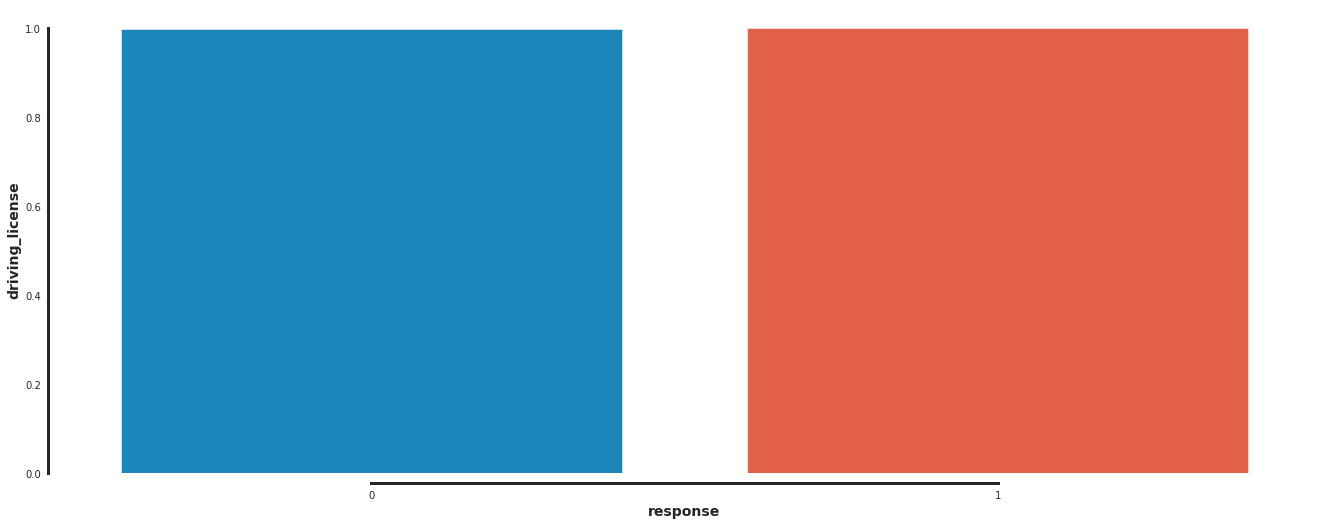

In [21]:
aux = df2[['driving_license', 'response']].groupby( 'response' ).mean().reset_index()
sns.barplot( x='response', y='driving_license', data=aux )
sns.despine(offset = 10, trim = True);

aux.head()

## 3.2 Different regions have different interest in insurance

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
region_code,38.000000,28.000000,19.000000,4.000000,23.000000,51.000000,24.000000,7.000000,18.000000,3.000000,35.000000,39.0000,52.000000,29.000000,41.000000
response,0.192004,0.187163,0.162866,0.158245,0.153061,0.153005,0.141615,0.131747,0.131574,0.127662,0.124604,0.1236,0.123596,0.123362,0.121776


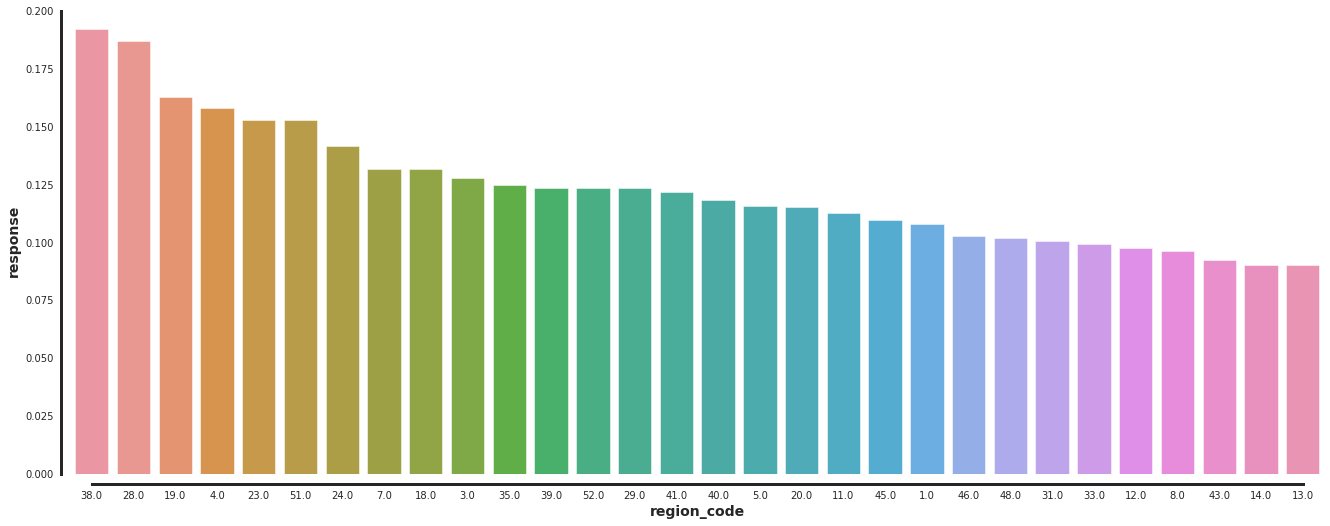

In [22]:
aux = df2[['region_code', 'response']].groupby('region_code').mean().sort_values(by = 'response', ascending = False).reset_index() 
sns.barplot(x = 'region_code', y = 'response', data = aux, order = aux['region_code'].head(30))
sns.despine(offset = 10, trim = True)
aux.head(15).T

## 3.3 Different policy sales channel have different outcome for the customer

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
policy_sales_channel,123.0,43.0,27.000000,28.000000,36.000000,155.000000,163.000000,3.000000,121.000000,101.000000,87.000000,80.000000,81.000000,158.00000,90.000000
response,1.0,1.0,0.333333,0.333333,0.326923,0.320097,0.304183,0.304015,0.296875,0.285714,0.285714,0.285714,0.285714,0.27439,0.269231


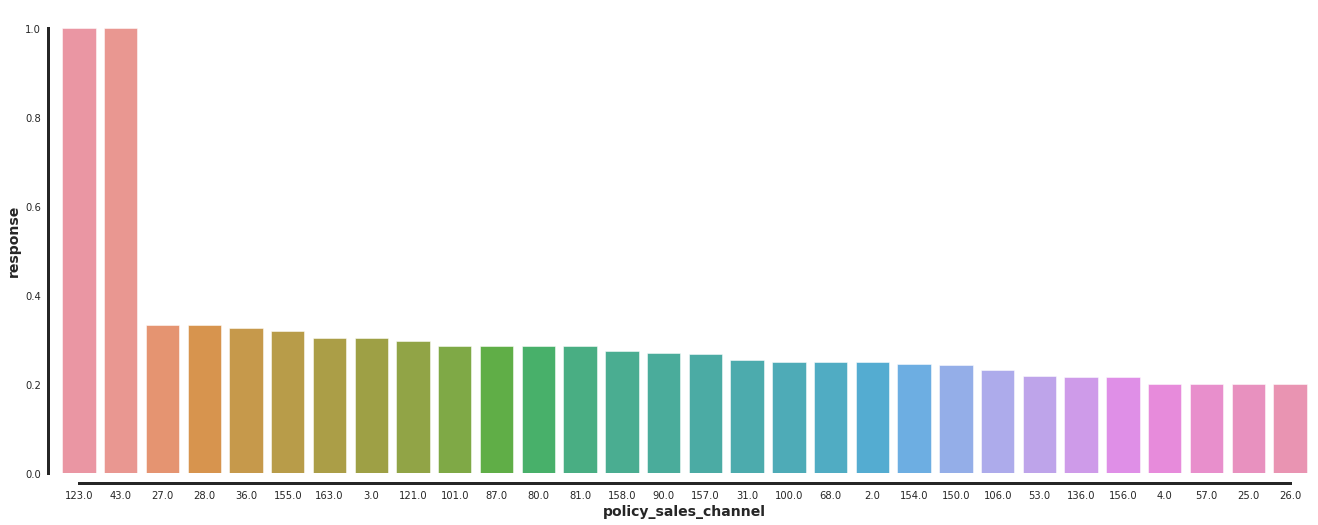

In [23]:
aux = df2[['policy_sales_channel', 'response']].groupby('policy_sales_channel').mean().sort_values(by = 'response', ascending = False).reset_index() 
sns.barplot(x = 'policy_sales_channel', y = 'response', data = aux.head(30), order = aux['policy_sales_channel'].head(30))
sns.despine(offset = 10, trim = True);
aux.head(15).T

## 3.4 Who was previosly insured is less likely to acquire a new insurance service

,response,previously_insured
0,0,0.521742
1,1,0.003383


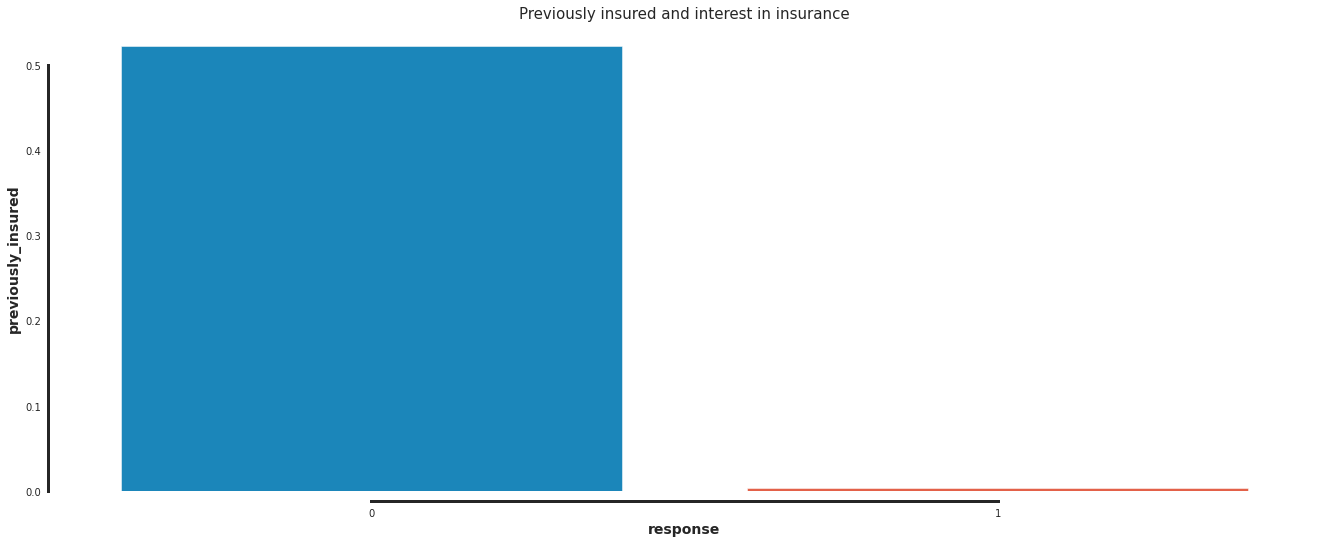

In [24]:
aux = df2[['previously_insured', 'response']].groupby( 'response' ).mean().reset_index()
sns.barplot( x='response', y='previously_insured', data=aux )
sns.despine(offset = 10, trim = True)
plt.title('Previously insured and interest in insurance');

aux.head()

## 3.5 The higher Annual Premium, the lower interest in insurance

In [25]:
aux1 = df2[df2['response'] == 1]
aux2 = df2[df2['response'] == 0]

x = aux1['annual_premium'].mean()
y = aux2['annual_premium'].mean()

print('Annual premium interested     (mean):', x)
print('Annual premium not interested (mean):', y)

Annual premium interested     (mean): 31604.092742453435
Annual premium not interested (mean): 30419.16027559891


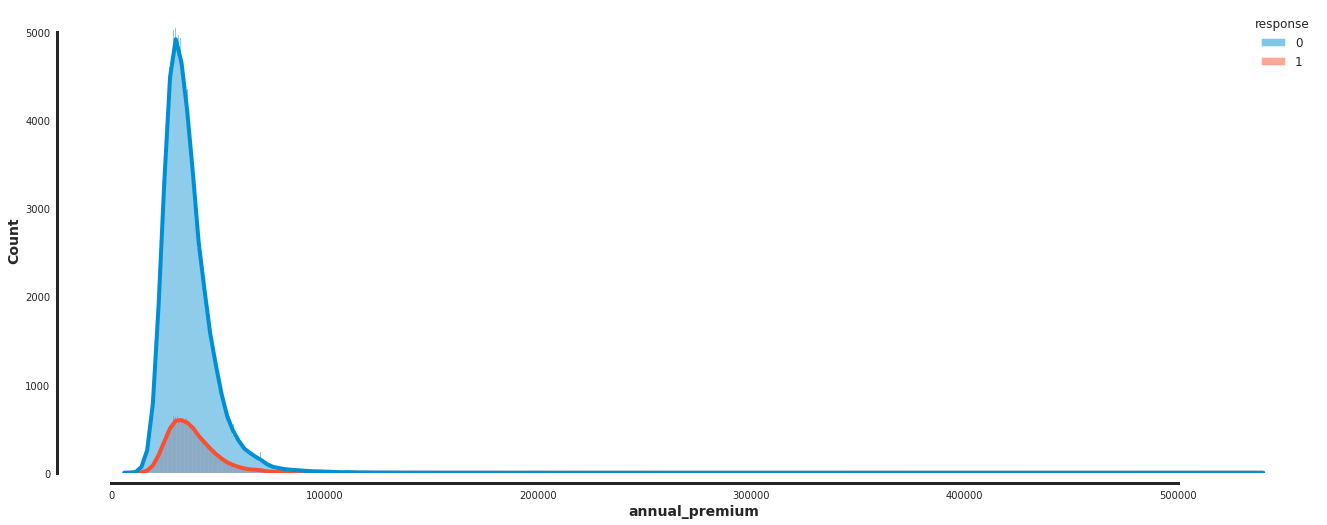

In [26]:
aux3 = df2[df2['annual_premium'] > 3000]

sns.histplot(aux3, x="annual_premium", hue="response", kde = True)
sns.despine(offset = 10, trim = True);

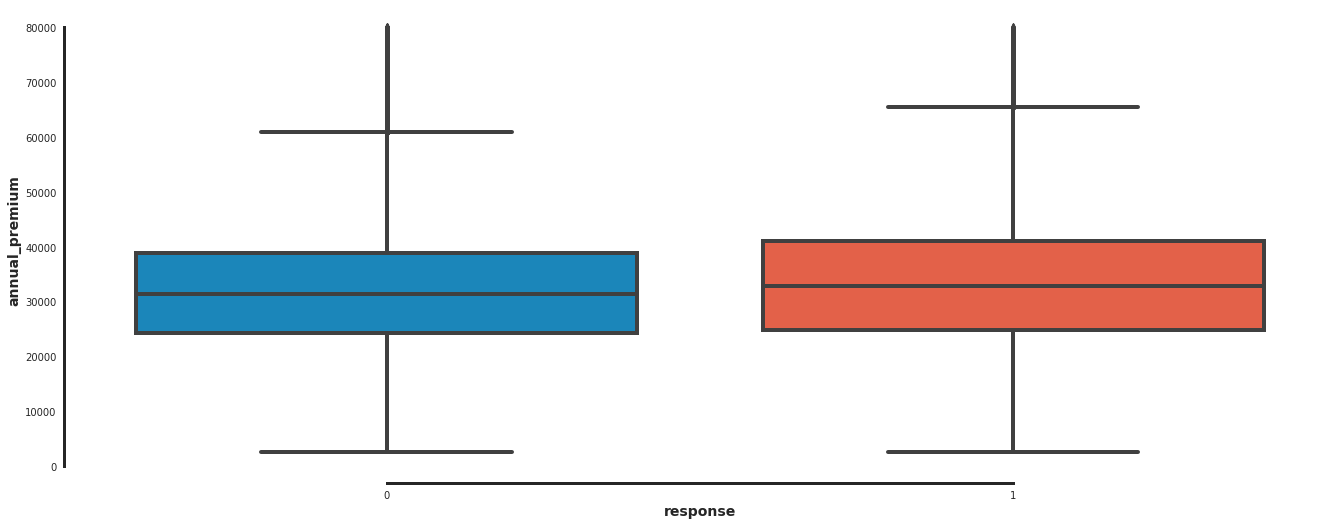

In [27]:
aux3 = df2[df2['annual_premium'] < 80000]
sns.boxplot(x = 'response',y = 'annual_premium', data = aux3)
sns.despine(offset = 10, trim = True);

## 3.6 The higher vintage, the higher interest in insurance

In [28]:
x = aux1['vintage'].mean()
y = aux2['vintage'].mean()

print('vintage of interested     (mean):', x)
print('vintage of not interested (mean):', y)

vintage of interested     (mean): 154.11224577178334
vintage of not interested (mean): 154.38024336197176


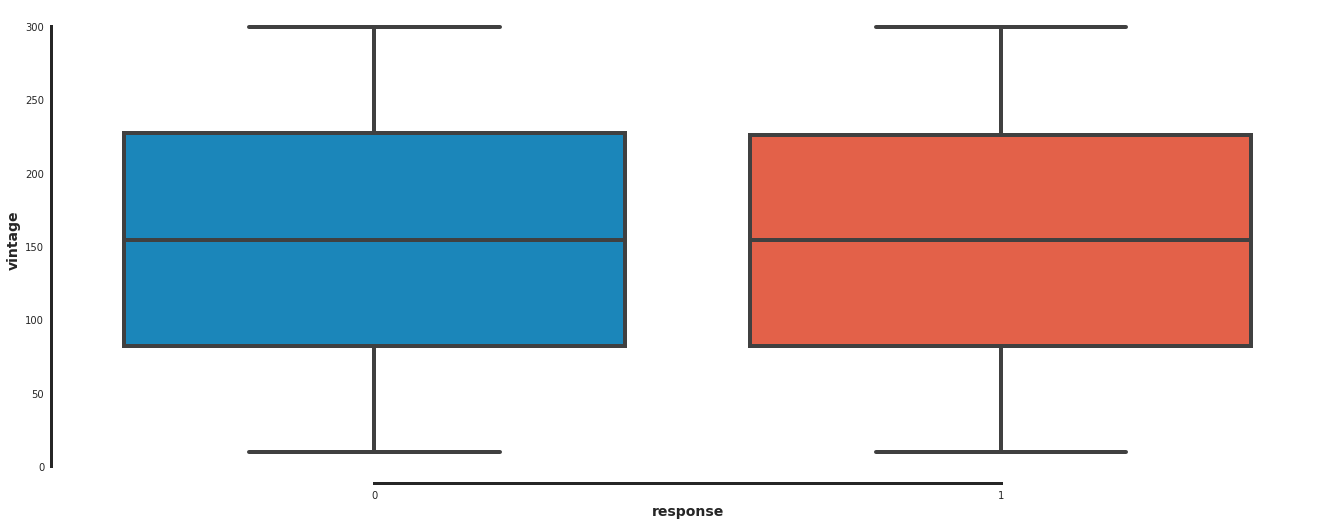

In [29]:
sns.boxplot(x = 'response', y = 'vintage', data = df2)
sns.despine(offset = 10, trim = True);

## 3.7 - The higher age, the higher interest in insurance

In [30]:
x = aux1['age'].mean()
y = aux2['age'].mean()

print('age of interested     (mean):', x)
print('age of not interested (mean):', y)

age of interested     (mean): 43.435559837293944
age of not interested (mean): 38.17822720761725


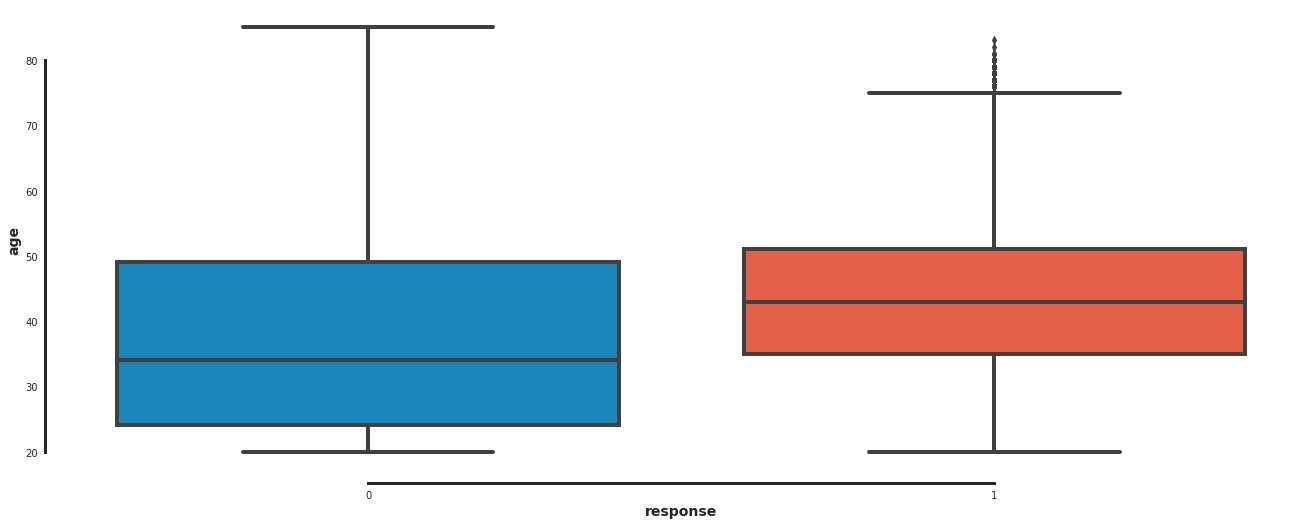

In [31]:
sns.boxplot(x = 'response', y = 'age', data = df2);
sns.despine(offset = 10, trim = True)

# 4.0 Bivariate Analysis

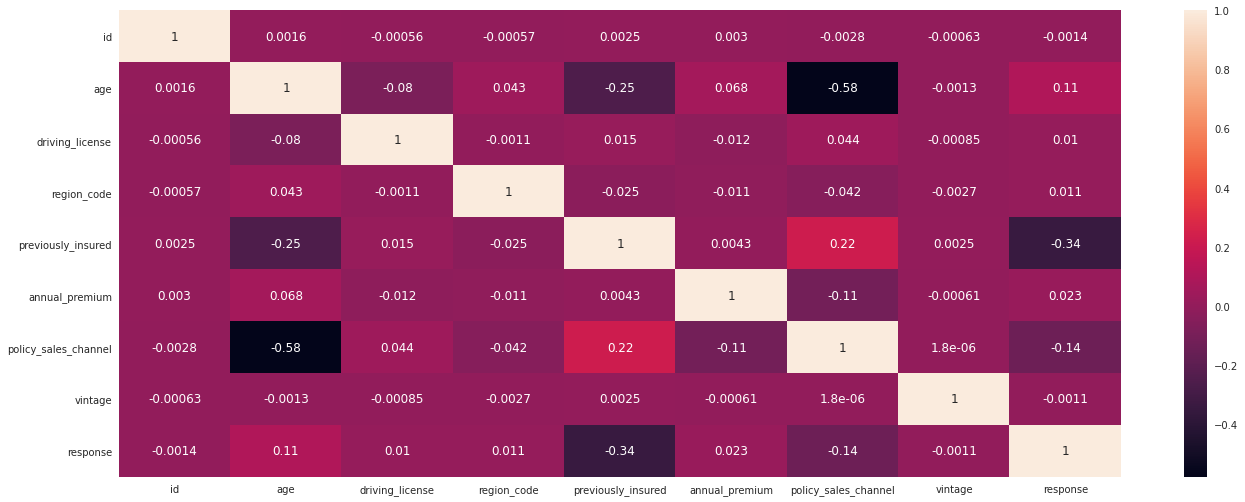

In [32]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

# 5.0 Data Preparation

In [33]:
df3 = df2.copy()

## 5.1 Encoding

In [34]:
#gender
df3['gender'] = df3['gender'].map( {'Male': 1, 'Female':0} )

#vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].map( {'Yes': 1, 'No':0} )

#vehicle_age
df3 = pd.get_dummies( df3, prefix='vehicle_age', columns=['vehicle_age'] )

In [35]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
0,1,1,44,1,28.0,0,1,40454.0,26.0,217,1,0,0,1
1,2,1,76,1,3.0,0,0,33536.0,26.0,183,0,1,0,0
2,3,1,47,1,28.0,0,1,38294.0,26.0,27,1,0,0,1
3,4,1,21,1,11.0,1,0,28619.0,152.0,203,0,0,1,0
4,5,0,29,1,41.0,1,0,27496.0,152.0,39,0,0,1,0


## 5.1.2 Target Encoding with Kfold

Targeting encoding using folds is meant to prevent overfitting in the training set. By using folds, instead of the entire training set, we average n folds to encode the category based on it's grouped mean. In the end, we print the correlation of the new feature with the target to see if the process is sustainable, i.e, the correlation is not very large. 

**Region Code**

In [36]:
target_encoder = KFoldTargetEncoder('region_code','response',n_fold=5)
df3 = target_encoder.fit_transform(df3)

df3[['region_code_Kfold_Target_Enc','region_code']].head(6)

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, region_code_Kfold_Target_Enc and, response is 0.13725713378653778.


,region_code_Kfold_Target_Enc,region_code
0,0.185753,28.0
1,0.129355,3.0
2,0.186828,28.0
3,0.114010,11.0
4,0.122466,41.0
5,0.099415,33.0


**Policy sales channel**

In [37]:
target_encoder = KFoldTargetEncoder('policy_sales_channel','response',n_fold=5)
df3 = target_encoder.fit_transform(df3)

df3[['policy_sales_channel_Kfold_Target_Enc','region_code']].head(6)

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, policy_sales_channel_Kfold_Target_Enc and, response is 0.26192635929712205.


,policy_sales_channel_Kfold_Target_Enc,region_code
0,0.199385,28.0
1,0.198666,3.0
2,0.198666,28.0
3,0.028425,11.0
4,0.028729,41.0
5,0.021735,33.0


## 5.2 Split Dataset

In [38]:
df3.drop(columns = [ 'policy_sales_channel', 'region_code', 'id'], inplace = True)

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_1-2 Year',
                 'vehicle_age_< 1 Year',
                 'vehicle_age_> 2 Years',
                 'region_code_Kfold_Target_Enc',
                 'policy_sales_channel_Kfold_Target_Enc', 
                 'response']

#keeping response as the last column for better slicing
df3 = df3.reindex(columns = columns_order)

## 5.2.1 Traning and test data

In [39]:
msk = np.random.rand(len(df)) < 0.80
train = df3[msk]
test = df3[~msk]

In [40]:
x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1:]

x_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1:]

## 5.3 Rescaling

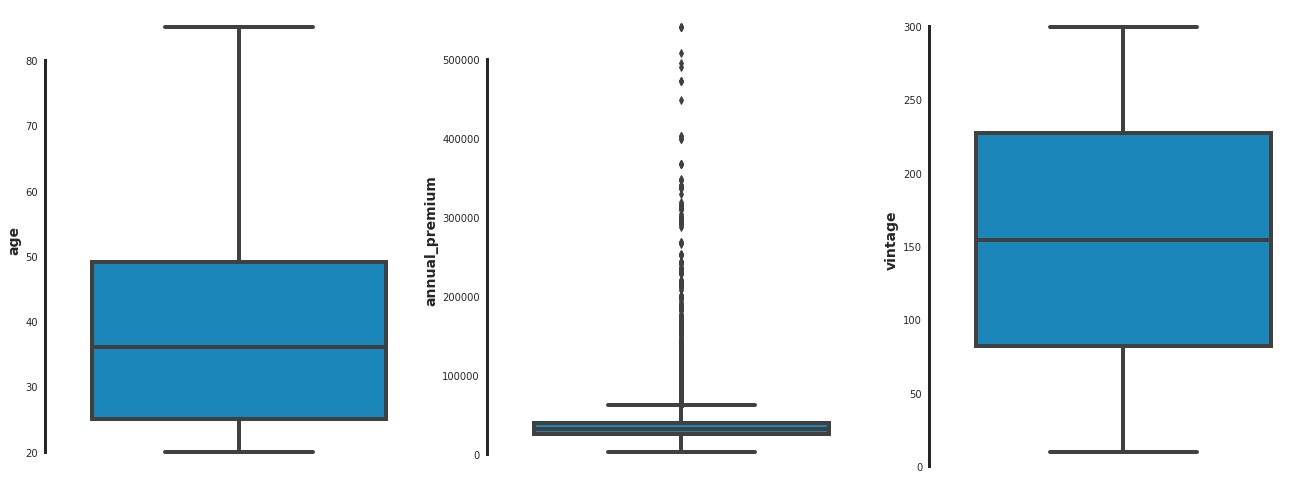

In [41]:
plt.subplot(1,3,1)
sns.boxplot(y = 'age', data = df2)
sns.despine(offset = 10, trim = True)

plt.subplot(1,3,2)
sns.boxplot(y= 'annual_premium', data = df2)
sns.despine(offset = 10, trim = True)

plt.subplot(1,3,3)
sns.boxplot(y= 'vintage', data = df2)
sns.despine(offset = 10, trim = True);

In [42]:
rs = RobustScaler() 
mms = MinMaxScaler()

#age
x_train['age'] = mms.fit_transform(x_train.loc[:, 'age':].values)
x_test['age'] = mms.transform(x_test.loc[:, 'age':].values)

#vintage
x_train['vintage'] = mms.fit_transform(x_train.loc[:, 'vintage':].values)
x_test['vintage'] = mms.transform(x_test.loc[:, 'vintage':].values)

#anual premium
x_train['annual_premium'] = rs.fit_transform(x_train.loc[:, 'annual_premium':].values)
x_test['annual_premium'] = rs.transform(x_test.loc[:, 'annual_premium':].values)

## 5.4 Target Variable Resampling

### 5.4.1 SMOTE + Tomek Links

In [43]:
print('Before ressampling')
y_train.value_counts()

Before ressampling


response
0           267437
1            37538
dtype: int64

In [44]:
#resample
x_train_res, y_train_res = SMOTETomek(random_state = 42).fit_resample(x_train, y_train)

In [45]:
print('After ressampling')
y_train_res.value_counts()

After ressampling


response
0           262582
1           262582
dtype: int64

# 6.0 Feature Selection

## 6.1.1 Feature Analysis

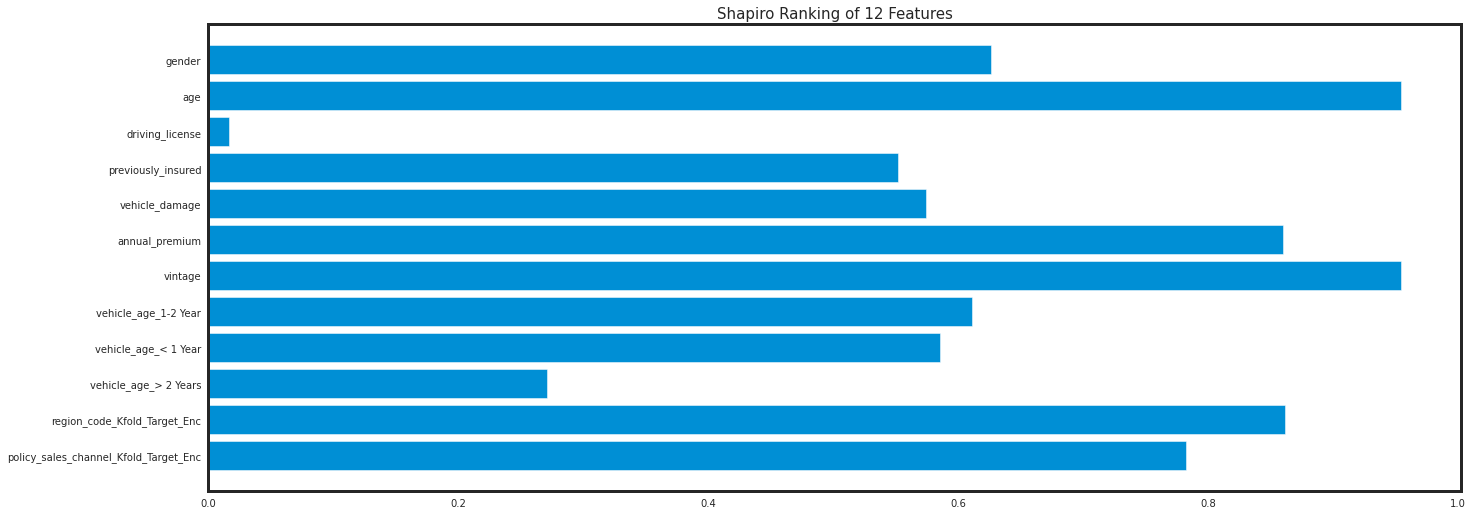

In [45]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x_train_res, y_train_res)           
visualizer.transform(x_train_res)        
visualizer.show();              

## 6.1.1 Recursive Feature Elimination with Cross Validation

In [100]:
#preparing for selection
x_train_res_s = x_train_res.values
y_train_res_s = y_train_res.values.ravel()

Optimal number of features : 3


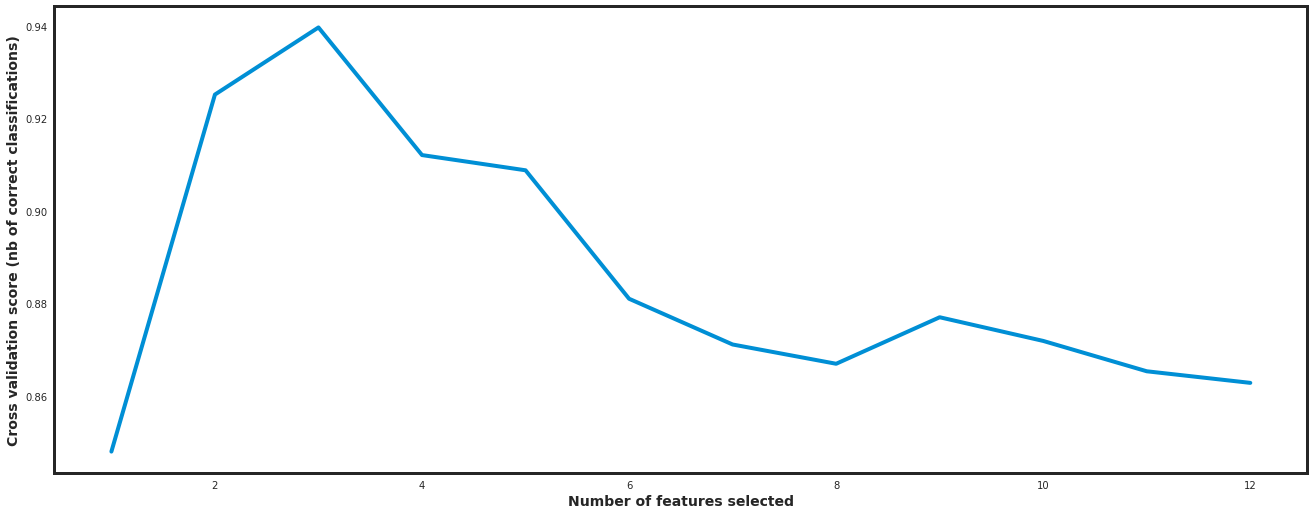

In [101]:
#Create the RFE object and compute a cross-validated score.
et = ExtraTreesClassifier( n_estimators = 100, n_jobs=-1, random_state=42 )

min_features_to_select = 1  # Minimum number of features to consider

rfeet = RFECV(estimator = et, step = 1, cv = StratifiedKFold(2),
              scoring = 'precision',
              min_features_to_select= min_features_to_select)

rfeet.fit(x_train_res_s, y_train_res_s)

print("Optimal number of features : %d" % rfeet.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfeet.grid_scores_) + min_features_to_select),
         rfeet.grid_scores_)
plt.show()

In [102]:
print('--- RFECV Selected Columns ---')
print(' ')

for i in range(x_train.shape[1]):
    
    if rfeet.support_[i] == True:
        print(str(df3.columns[i]))
        print('Rank: %.2f' % rfeet.ranking_[i])
        print(' ')
    else:
        pass

--- RFECV Selected Columns ---
 
age
Rank: 1.00
 
vehicle_damage
Rank: 1.00
 
policy_sales_channel_Kfold_Target_Enc
Rank: 1.00
 


## 6.1.2 Boruta Algorithm (Wrapper Method) 

In [104]:
#define Classifier
rf = RandomForestClassifier( n_jobs = -1 )

boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( x_train_res_s, y_train_res_s )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	6


In [105]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train.columns, cols_selected_boruta ) )

In [106]:
cols_selected_boruta

['age',
 'previously_insured',
 'vehicle_damage',
 'vintage',
 'region_code_Kfold_Target_Enc',
 'policy_sales_channel_Kfold_Target_Enc']

In [107]:
cols_not_selected_boruta

['annual_premium',
 'driving_license',
 'gender',
 'vehicle_age_1-2 Year',
 'vehicle_age_< 1 Year',
 'vehicle_age_> 2 Years']

# 7.0 Modeling

**Selected columns from feature analysis and selection**

In [50]:
cols_selected = [   'age',
                    'previously_insured',
                    'vehicle_damage',
                    'vintage',
                    'annual_premium',
                    'region_code_Kfold_Target_Enc',
                    'policy_sales_channel_Kfold_Target_Enc'
                ]

In [51]:
x_train_res = x_train_res[cols_selected]
x_test = x_test[cols_selected]

## Disclaimer

Since we're dealing with a imbalanced dataset, we have to be careful with metrics. Using precision in test set, for example, we would expect to see a very low number, once there is a large number of people not interested in **insurance (0)** rather than people **interested (1)**.

Remember precision is $ \frac{TP}{TP+FP}$ 

On test set, the number of false positives is very large, since there's more examples of zeros than ones. 

Metrics at k (Learning to rank metrics), such as precision and recall at k, can me influenced by the differences in size and classes of test and validation data too. 

To solve that, I will evaluate (check for out of sample performance) the models using balanced accuracy score. I'll use recall, precision and learning to rank metrics to select the best model with cross-validated scores, since the validation set is balanced. To adress the business problem, I'll use lift and cumulative gains curve of the selected model. 

## 7.1 Logistic Regression

In [52]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 ) 

# model training
lr_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_lr = lr_model.predict( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_lr)))

Balanced Accuracy: 0.7909706402729237


## 7.2 K-Nearest Neighbors

In [53]:
#find best k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train_res,y_train_res.values.ravel())
    yhat = knn_model.predict(x_test)
    mean_rcc[n-1] = balanced_accuracy_score(y_test, yhat)

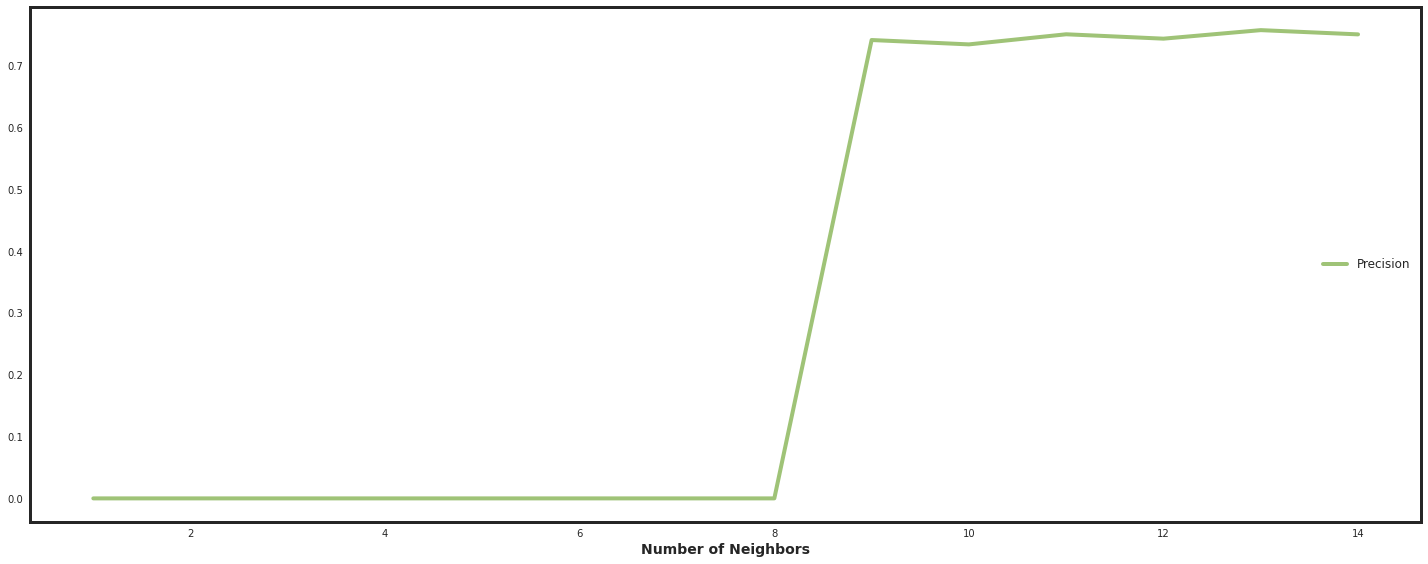

In [54]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [55]:
# model definition with k = 10
knn_model = nh.KNeighborsClassifier( n_neighbors = 10 )

# model training
knn_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_knn = knn_model.predict( x_test ) 

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_knn)))

Balanced Accuracy: 0.7344249704511152


## 7.3 Extra Trees

In [56]:
# model definition
et = ExtraTreesClassifier( n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train_res, y_train_res.values.ravel() )

# model prediction
yhat_et = et.predict(x_test)

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_et)))

Balanced Accuracy: 0.6369611062808591


## 7.4 XGBoost Classifier 

In [57]:
# model definition
model_xgb = xgb.XGBClassifier(n_estimators = 7, 
                              eta = 0.01, 
                              max_depth = 2, 
                              subsample = 0.7,
                              use_label_encoder = False,
                              eval_metric = 'aucpr',
                              colsample_bytree = 0.9)

#model training
model_xgb.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_xgb = model_xgb.predict( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_xgb)))

Balanced Accuracy: 0.7837283516099562


## 7.5 Gaussian NB Classifier

In [58]:
#model definition
model_nb = GaussianNB()

#train model
model_nb.fit( x_train_res, y_train_res.values.ravel() )

#prediction
yhat_nb = model_nb.predict( x_test )
yhat_nb_1 = model_nb.predict_proba( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_nb)))

Balanced Accuracy: 0.7839644176993694


## 7.6 Random Forest Classifier

In [59]:
#model definition
model_rf = RandomForestClassifier(max_depth = 2, random_state = 0)

#train model
model_rf.fit( x_train_res, y_train_res.values.ravel() )

#predict
yhat_rf = model_rf.predict( x_test )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_rf)))

Balanced Accuracy: 0.7923391237915034


## 8.0 Real Model Performance: Cross Validation with Learning to Rank metrics

In [60]:
df4 = df3.copy()

In [61]:
xgb_val = cross_validation(model_xgb, x_train_res, y_train_res, 5, df4, Verbose = False)
lr_val = cross_validation(lr_model, x_train_res, y_train_res, 5, df4, Verbose = False)
et_val = cross_validation(et, x_train_res, y_train_res, 5, df4, Verbose = False)
nb_val = cross_validation(model_nb, x_train_res, y_train_res, 5, df4, Verbose = False)
rf_val = cross_validation(model_rf, x_train_res, y_train_res, 5, df4, Verbose = False)

In [62]:
results = pd.concat([xgb_val,lr_val,et_val,nb_val,rf_val])
results.sort_values(by = 'Recall Mean', ascending = False)

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,GaussianNB,0.7895,0.7101,0.0013,0.9785,0.0006,0.7829,0.0030,0.2982,0.0011
0,ExtraTreesClassifier,0.9150,0.8864,0.0013,0.9520,0.0010,0.9986,0.0002,0.3803,0.0001
0,RandomForestClassifier,0.8013,0.7375,0.0018,0.9358,0.0054,0.8528,0.0055,0.3248,0.0021
0,LogisticRegression,0.7968,0.7331,0.0015,0.9334,0.0015,0.7880,0.0040,0.3001,0.0015
0,XGBClassifier,0.7869,0.7430,0.0031,0.8774,0.0049,0.7966,0.0343,0.3034,0.0131


# 9.0 Hyperparameter Fine Tuning

We will proceed with both Gaussian Naive Bayes and ExtraTrees Classifier, using Optuna framework to tune them

## 9.1 Extra Trees Classifier

In [63]:
def objective(trial):

       random_state = 42
        n_jobs = -1
        max_depth = trial.suggest_int("max_depth", 80, 120)
        n_estimators = trial.suggest_int("n_estimators", 80, 120)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    

        classifier_obj = ExtraTreesClassifier(random_state       = random_state,
                                              n_jobs             = n_jobs,
                                              max_depth          =  max_depth,
                                              n_estimators       = n_estimators,
                                              min_samples_split  = min_samples_split,
                                              min_samples_leaf   = min_samples_leaf
                                              
                                             )

  
        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df4, Verbose = False)
    
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Recall: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

## 9.2 Gaussian Naive Bayes 

In [135]:
def objective(trial):

        
       
        var_smoothing = trial.suggest_float('var_smoothing',1e-9, 1, log = True )
        

        classifier_obj = GaussianNB( var_smoothing = var_smoothing )
        

        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df4, Verbose = False)
        
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Recall: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-03-17 15:02:28,759] A new study created in memory with name: no-name-d1c110e6-e724-4815-89ff-a177c25bddbe
[I 2021-03-17 15:02:29,647] Trial 0 finished with value: 0.9789 and parameters: {'var_smoothing': 7.623331832466821e-06}. Best is trial 0 with value: 0.9789.
[I 2021-03-17 15:02:30,542] Trial 1 finished with value: 0.9789 and parameters: {'var_smoothing': 1.4319058623079976e-07}. Best is trial 0 with value: 0.9789.
[I 2021-03-17 15:02:31,420] Trial 2 finished with value: 0.979 and parameters: {'var_smoothing': 0.11506215091761057}. Best is trial 2 with value: 0.979.
[I 2021-03-17 15:02:32,282] Trial 3 finished with value: 0.9793 and parameters: {'var_smoothing': 0.3642393900791821}. Best is trial 3 with value: 0.9793.
[I 2021-03-17 15:02:33,141] Trial 4 finished with value: 0.9789 and parameters: {'var_smoothing': 2.5664956878698938e-08}. Best is trial 3 with value: 0.9793.
[I 2021-03-17 15:02:34,004] Trial 5 finished with value: 0.9793 and parameters: {'var_smoothing': 0.4

Precision: 0.9794
Best hyperparameters: {'var_smoothing': 0.8543997666089961}


# 10.0 Final Model

## 10.1 Gaussian Naive Bayes

In [159]:
#definition
model_nb = GaussianNB() 
#training
model_nb.fit( x_train_res, y_train_res.values.ravel() )

# model prediction
yhat_nb = model_nb.predict_proba(x_test)

# 11.0 Business Performance

## By using 26% of test data, in which wold translate as 20 thousand calls by the sales team, the model would be able to identify 65.5% people out of the total people interested in purchasing the insurance

In [160]:
data = x_test.copy()

data['response'] = y_test.copy()
data['score'] = yhat_nb[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [161]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)

print(percent_of_dataset)
print(recall_at_20000)

0.2634490752937457
0.6557640750670242


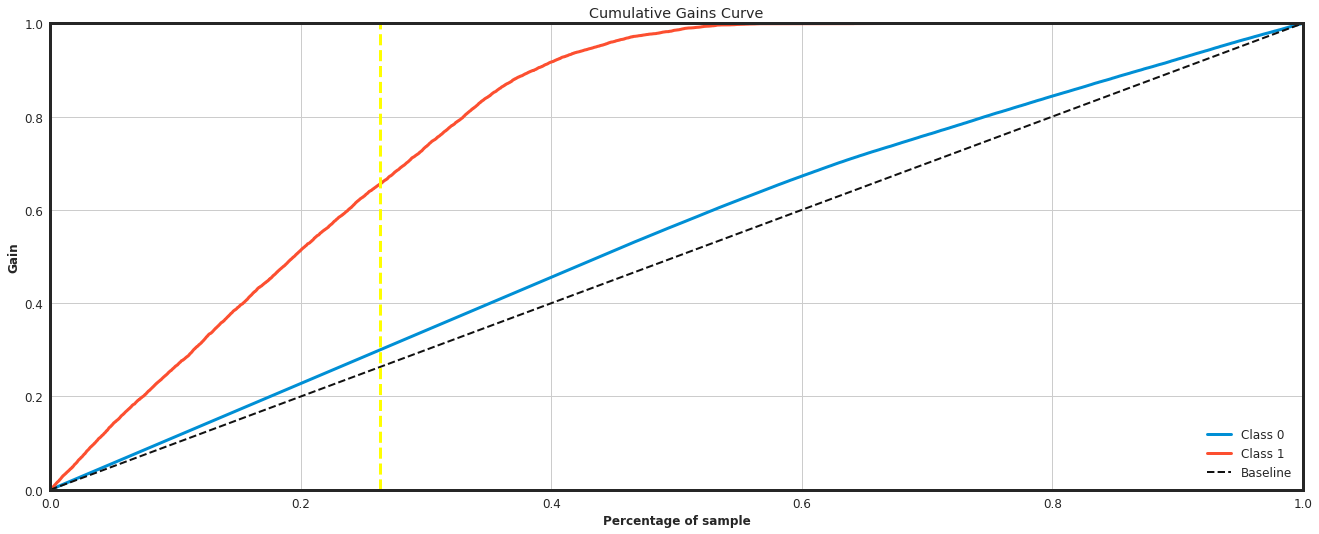

In [178]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
plt.axvline(0.2634, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

## By using a little less then 33% of test data, in which wold translate as 25 thousand and 1 hundred calls by the sales team, the model would be able to identify 80% people out of the total people interested in purchasing the insurance

In [176]:
percent_of_dataset = 25100 / len(data)
recall_at_25100 = recall_at_k(data, k = 25100)

print(percent_of_dataset)
print(recall_at_25100)

0.33062858949365087
0.8016085790884718


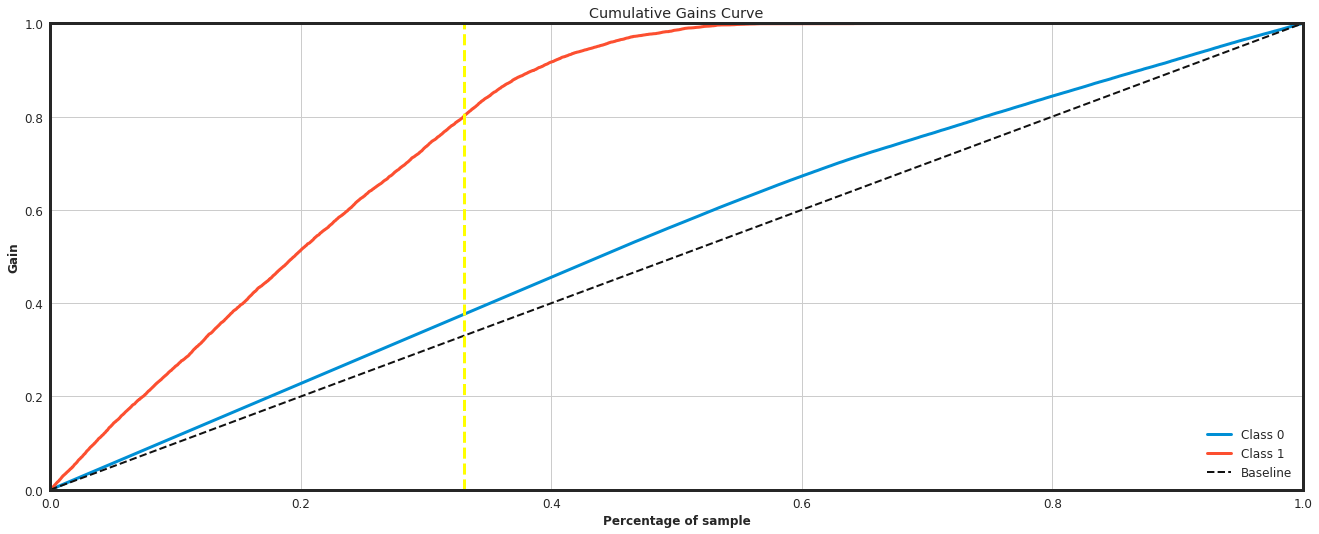

In [177]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
plt.axvline(0.3306, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

## By Making 20 thousand calls, the model proposed is roughly 2,5 times better than random choice

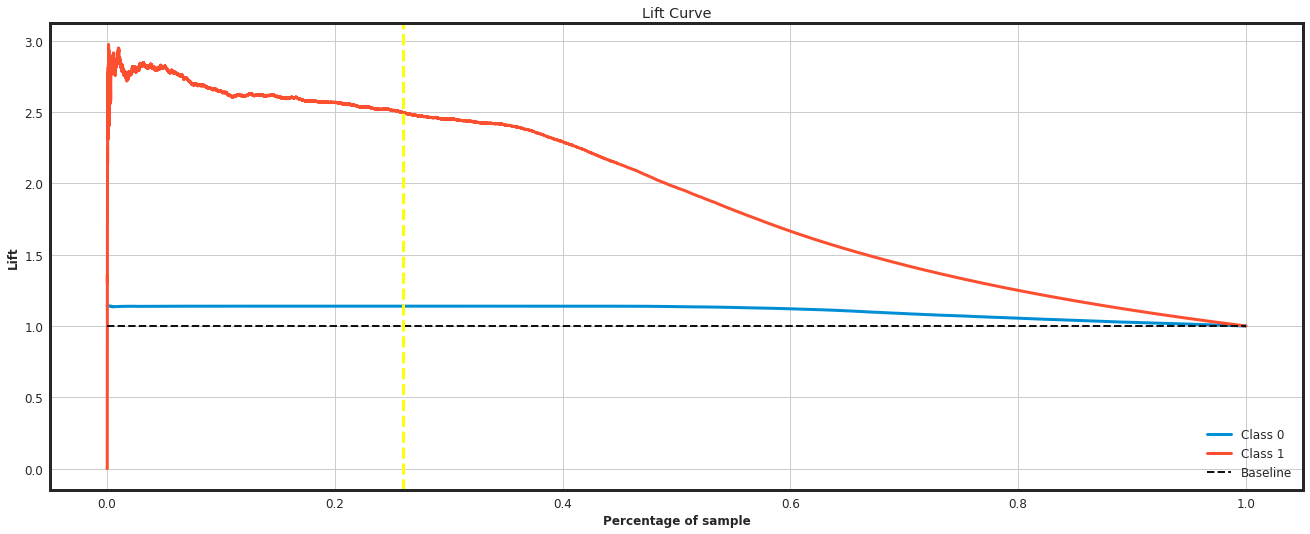

In [165]:
skplt.metrics.plot_lift_curve(y_test, yhat_nb)
plt.axvline(0.26, 0, 1, color='yellow', ls='--', lw=3);

## Baseline model would predict 26% of all people interested in insurance by making 20 thousand calls, whereas, our model, would predict 65.5%. If each insurance is 1000 this represents a diference of 29,60 million dollars in 20 thousand calls

In [180]:
random_choice = (26/100) * len(data)
model         = (65/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

19738160 revenue with random choice
49345400 revenue with model
difference in $: 29607240


## With 26 thousand calls and 4 hundred, our model would predict 80% of all people interested, and the difference from baseline would rise to 35,7 million dollars

In [181]:
random_choice = (33/100) * len(data)
model         = (80/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

25052280 revenue with random choice
60732800 revenue with model
difference in $: 35680520
